In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os

# Authenticate Kaggle API
api = KaggleApi()
api.authenticate()

# Correct dataset name
dataset_name = 'farzadnekouei/gold-price-10-years-20132023'  # Replace with actual dataset name

# Define the download path (use raw string for Windows path)
download_path = r"D:\Deep_Learning\Goldprice_prediction"

# Create the folder if it doesn’t exist
os.makedirs(download_path, exist_ok=True)

# Download and unzip the dataset
api.dataset_download_files(dataset_name, path=download_path, unzip=True)

print(f"Dataset downloaded successfully to: {download_path}")

Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/gold-price-10-years-20132023
Dataset downloaded successfully to: D:\Deep_Learning\Goldprice_prediction


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import intel_tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import warnings

In [3]:
df= pd.read_csv(r"D:\Deep_Learning\GoldPrice_prediction\Gold Price (2013-2023).csv")
df.count()

Date        2583
Price       2583
Open        2583
High        2583
Low         2583
Vol.        2578
Change %    2583
dtype: int64

In [4]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df

,Date,Price,Open,High,Low
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80"
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20"
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20"
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00"
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55"
...,...,...,...,...,...
2578,01/08/2013,"1,663.20","1,651.50","1,662.60","1,648.80"
2579,01/07/2013,"1,647.20","1,657.30","1,663.80","1,645.30"
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00"
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30"


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
# Clean 'Price' column: remove commas and convert to float
if df['Price'].dtype == 'object':
    df['Price'] = df['Price'].str.replace(',', '').astype(float)

df

,Price,Open,High,Low
Date,,,,
2022-12-30,1826.2,"1,821.80","1,832.40","1,819.80"
2022-12-29,1826.0,"1,812.30","1,827.30","1,811.20"
2022-12-28,1815.8,"1,822.40","1,822.80","1,804.20"
2022-12-27,1823.1,"1,808.20","1,841.90","1,808.00"
2022-12-26,1809.7,"1,805.80","1,811.95","1,805.55"
...,...,...,...,...
2013-01-08,1663.2,"1,651.50","1,662.60","1,648.80"
2013-01-07,1647.2,"1,657.30","1,663.80","1,645.30"
2013-01-04,1649.9,"1,664.40","1,664.40","1,630.00"


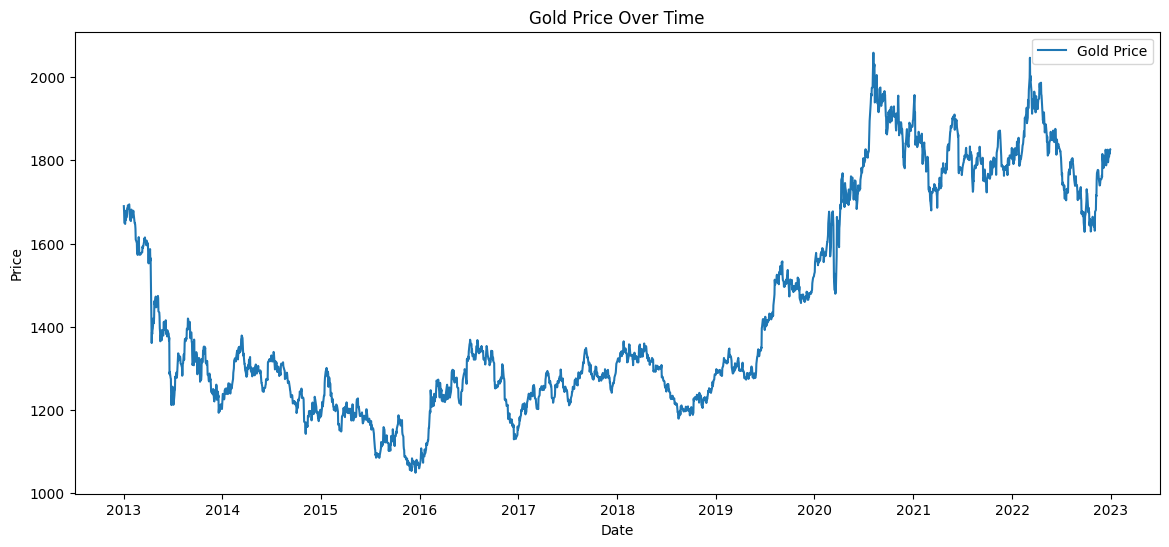

In [6]:
# Plot the gold price over time
plt.figure(figsize=(14, 6))  # Set figure size
plt.plot(df['Price'], label='Gold Price')  # Line plot of gold prices
plt.title('Gold Price Over Time')  # Title of the plot
plt.xlabel('Date')  # Label x-axis
plt.ylabel('Price')  # Label y-axis
plt.legend()  # Show legend
plt.show()  # Display plot

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Price']])  # Must be a 2D array
scaled_data

array([[0.76982554],
       [0.76962728],
       [0.75951626],
       ...,
       [0.59506344],
       [0.62053925],
       [0.63471451]])

In [8]:
# -----------------------------
# Step 3: Create sequences for LSTM
# -----------------------------

# Define a function to create input/output pairs from the time series
def create_sequences(data, seq_length=60):
    X = []  # Input sequences
    y = []  # Corresponding targets
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i, 0])  # Previous 60 values
        y.append(data[i, 0])  # Target value (the next one)
    return np.array(X), np.array(y)  # Return as NumPy arrays


In [9]:

# -----------------------------
# Step 4: Split data into train and test sets
# -----------------------------

# Use 80% of data for training
train_size = int(len(scaled_data) * 0.8)
print(f"Train size: {train_size}, Test size: {len(scaled_data) - train_size}")
# Split data into training and testing portions
train_data = scaled_data[:train_size]  # First 80%
test_data = scaled_data[train_size - 60:]  # Remaining, including last 60 for sequence

# Create training sequences
X_train, y_train = create_sequences(train_data)

# Create testing sequences
X_test, y_test = create_sequences(test_data)

# Reshape input to be 3D for LSTM: (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # 3D shape
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


Train size: 2066, Test size: 517


In [10]:

# -----------------------------
# Step 5: Build the LSTM model
# -----------------------------

# Initialize a Sequential model
model = Sequential()

# Add a single LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))

# Add a Dense output layer with 1 neuron (predicting 1 price)
model.add(Dense(1))

# Compile the model with Adam optimizer and MSE loss
model.compile(optimizer='adam', loss='mean_squared_error')

# -----------------------------
# Step 6: Train the model
# -----------------------------

# Train the model with training data
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)



Epoch 1/20


c:\Users\chint\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1091 - val_loss: 0.0026
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0013 - val_loss: 7.8962e-04
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0011 - val_loss: 7.4668e-04
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0011 - val_loss: 6.5998e-04
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 9.9932e-04 - val_loss: 6.1979e-04
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0010 - val_loss: 6.4984e-04
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.2356e-04 - val_loss: 5.7608e-04
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.8780e-04 - val_loss: 5.4272e-04
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.3228e-04 - val_loss: 5.5806e-04
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.9290e-04 - val_loss: 5.1391e-04
Epoch 11/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.8579e-04 - val_loss: 5.0683e-04
Epoch 12/2

In [11]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9696e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [12]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0009216922917403281
Test MAPE: 0.08388053809137311
Test Accuracy: 0.9161194619086269


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[1223.3712]
 [1216.1627]
 [1209.2612]
 [1204.6333]
 [1199.4108]
 [1196.0923]
 [1191.6604]
 [1187.9811]
 [1185.0195]
 [1184.192 ]
 [1184.1411]
 [1184.6085]
 [1185.3512]
 [1187.4869]
 [1191.3381]
 [1195.8535]
 [1200.7609]
 [1205.7079]
 [1206.6897]
 [1205.8951]
 [1205.7931]
 [1205.6781]
 [1204.6724]
 [1205.2672]
 [1202.1252]
 [1198.2662]
 [1196.2448]
 [1194.8229]
 [1193.7844]
 [1193.2606]
 [1192.3762]
 [1191.8392]
 [1191.7512]
 [1190.5675]
 [1189.4106]
 [1186.0046]
 [1181.9619]
 [1178.2186]
 [1174.4951]
 [1172.0778]
 [1167.8031]
 [1163.7919]
 [1162.113 ]
 [1161.5568]
 [1161.8676]
 [1165.1398]
 [1171.6615]
 [1179.4574]
 [1187.4   ]
 [1195.1335]
 [1201.8707]
 [1209.1985]
 [1216.474 ]
 [1222.3651]
 [1226.665 ]
 [1230.0638]
 [1232.9368]
 [1234.1351]
 [1234.1407]
 [1232.7104]
 [1231.108 ]
 [1227.4883]
 [1224.1401]
 [1220.4485]
 [1215.5905]
 [1212.9464]
 [1211.1536]
 [1209.6654]
 [1209.2852]
 [1208.9939]
 [1209.5659]
 [1210.1719]
 [1211.0925]
 [1211.6555]

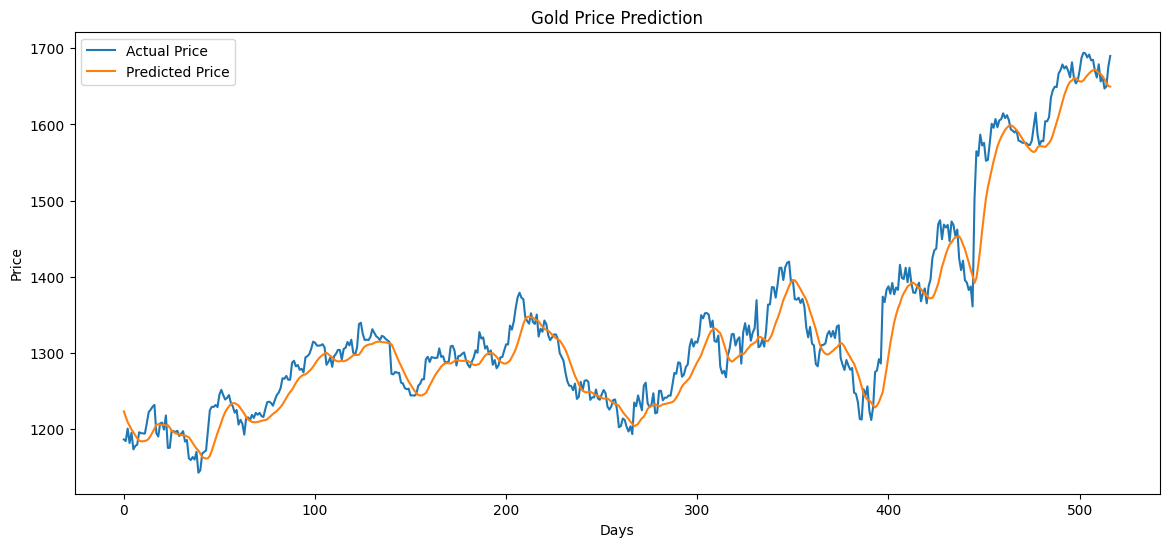

In [20]:

# -----------------------------
# Step 7: Make predictions
# -----------------------------

# Predict using the test set
predicted_price = model.predict(X_test)

# Inverse transform predictions back to original scale
predicted_price = scaler.inverse_transform(predicted_price)

# Inverse transform actual test prices for comparison
actual_price = scaler.inverse_transform(y_test.reshape(-1, 1))
print(predicted_price, actual_price)  # Print first 5 predicted prices
# -----------------------------
# Step 8: Visualize results
# -----------------------------

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(actual_price, label='Actual Price')  # True prices
plt.plot(predicted_price, label='Predicted Price')  # Model's predictions
plt.title('Gold Price Prediction')  # Title
plt.xlabel('Days')  # X-axis label
plt.ylabel('Price')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Show the plot